In [1]:
import sys
sys.path.append('..')

import qrcode
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
import collections
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
from sqlalchemy import create_engine, text
from datetime import datetime

from matplotlib.patches import Patch

In [2]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [3]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

def obtener_parte_diario_sin_cod_labor():
    engine = obtener_engine()
    try:
        query = """
            SELECT DISTINCT idd, unidad_01, unidad_02
            FROM drones_pulverizacion.parte_diario_pulv 
            WHERE idd IS NOT NULL AND cod_labor IS NULL
        """
        # Usar pandas si no hay geometría involucrada
        df = pd.read_sql(query, engine)
        return df
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return pd.DataFrame()
    return None

def obtener_propiedad_por_idd(idd):
    engine = obtener_engine()
    try:
        query = f"""
            SELECT * FROM drones_pulverizacion.parte_diario_pulv WHERE idd= {idd}
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

# retorna un valor con el cod mayor de cod_labor
def obtener_cod_labor_actual():
    engine = obtener_engine()
    try:
        query = f"""
            select max(cast(split_part(cod_labor, '-', 3) as integer)) 
            from drones_pulverizacion.parte_diario_pulv 
            where cod_labor is not null
        """
        df = pd.read_sql(query, engine)
        return df
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return pd.DataFrame()
    return None

def actualizar_cod_labor_por_idd(idd, cod_labor):
    engine = obtener_engine()
    try:
        with engine.begin() as conn:
            query = text("""
                update drones_pulverizacion.parte_diario_pulv 
                set cod_labor = :cod_labor 
                where idd = :idd
            """)
            conn.execute(query, {"idd": idd, "cod_labor": cod_labor})
            print(f"✔️ Cod_Lobor: {cod_labor} actualziado correctamente en idd: {idd}")
    except Exception as e:
        print(f"❌ Error al actualizar cod_labor: {e}")

def generar_plano_pulv(shp_prop, shp_plan, shp_recorrido, path_tif, path_out):
    # Cargar la imagen TIFF con rasterio
    with rasterio.open(path_tif) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
        img = src.read([1, 2, 3])  # Leer las bandas RGB
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='blue', facecolor=(0, 0, 0, 0), linewidth=1)
    shp_plan.plot(ax=ax, edgecolor='yellow', facecolor=(0, 0, 0, 0), linewidth=1)
    shp_recorrido.plot(ax=ax, color='red', linewidth=0.5, linestyle="-", label="Líneas")
    # Agregar etiquetas con lote mas area
    for idx, row in shp_plan.iterrows():
        if row.geom is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geom.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])
    # 🔹 **Agregar Leyenda**
    legend_elements = [
        #facecolor=(R, G, B, Alpha)
        Patch(facecolor=(0, 0, 0, 0), edgecolor='blue', label='Lotes Propiedad'),
        Patch(facecolor=(0, 0, 0, 0), edgecolor='yellow', label='Lotes Aplicados'),
        # Líneas (Caminos, canales, etc.)
        Line2D([0], [0], color='red', linewidth=1, linestyle="-", label='Recorrido de Dron'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    # Guardar plano
    fig.savefig(path_out, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

def insertar_datos_resumen(datos):
    engine = obtener_engine()

    valores = {
        'fecha': datetime.strptime(str(datos.fecha), '%d-%m-%Y').date(),
        'inst': int(datos.inst),
        'cod_ca': int(datos.cod_ca),
        'nom_ca': datos.nom_ca,
        'total_pulv': float(datos.total_pulv),
        'n_labor': datos.n_labor,
        'cod_prop': int(datos.cod_prop),
        'nom_prop': datos.nom_prop
    }

    query = text("""
        INSERT INTO drones_pulverizacion.resumen_pulv (
            fecha, institucion, cod_canero, nombre_canero, hectareas, cite, cod_propiedad, propiedad
        ) VALUES (
            :fecha, :inst, :cod_ca, :nom_ca, :total_pulv, :n_labor, :cod_prop, :nom_prop
        )
        ON CONFLICT (cite) DO UPDATE SET
            fecha = EXCLUDED.fecha,
            institucion = EXCLUDED.institucion,
            cod_canero = EXCLUDED.cod_canero,
            nombre_canero = EXCLUDED.nombre_canero,
            hectareas = EXCLUDED.hectareas,
            cod_propiedad = EXCLUDED.cod_propiedad,
            propiedad = EXCLUDED.propiedad
    """)

    with engine.begin() as conn:
        conn.execute(query, valores)

    print("✅ Registro insertado o actualizado exitosamente en RESUMEN de pulverización.")

In [4]:
path_shp_cat = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_shp_recorridos = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\RECORRIDOS.shp'
#path_shp_plan = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
#path_xlsx_parte = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

In [5]:
gdf_cat = gpd.read_file(path_shp_cat)
gdf_recorridos = gpd.read_file(path_shp_recorridos)

#gdf_plan = gpd.read_file(path_shp_plan)
#df_parte = pd.read_excel(path_xlsx_parte)

In [6]:
idds_procesar = obtener_parte_diario_sin_cod_labor()
idds_procesar

,idd,unidad_01,unidad_02
0,60,482,TEXAS
1,61,480,EL CANAL
2,59,2250,COSORIOCITO


In [7]:
for idx, row in idds_procesar.iterrows():
    print(row.idd)
    print(row.unidad_01)

60
482
61
480
59
2250


In [24]:
idd = 59
cod_prop = 2250

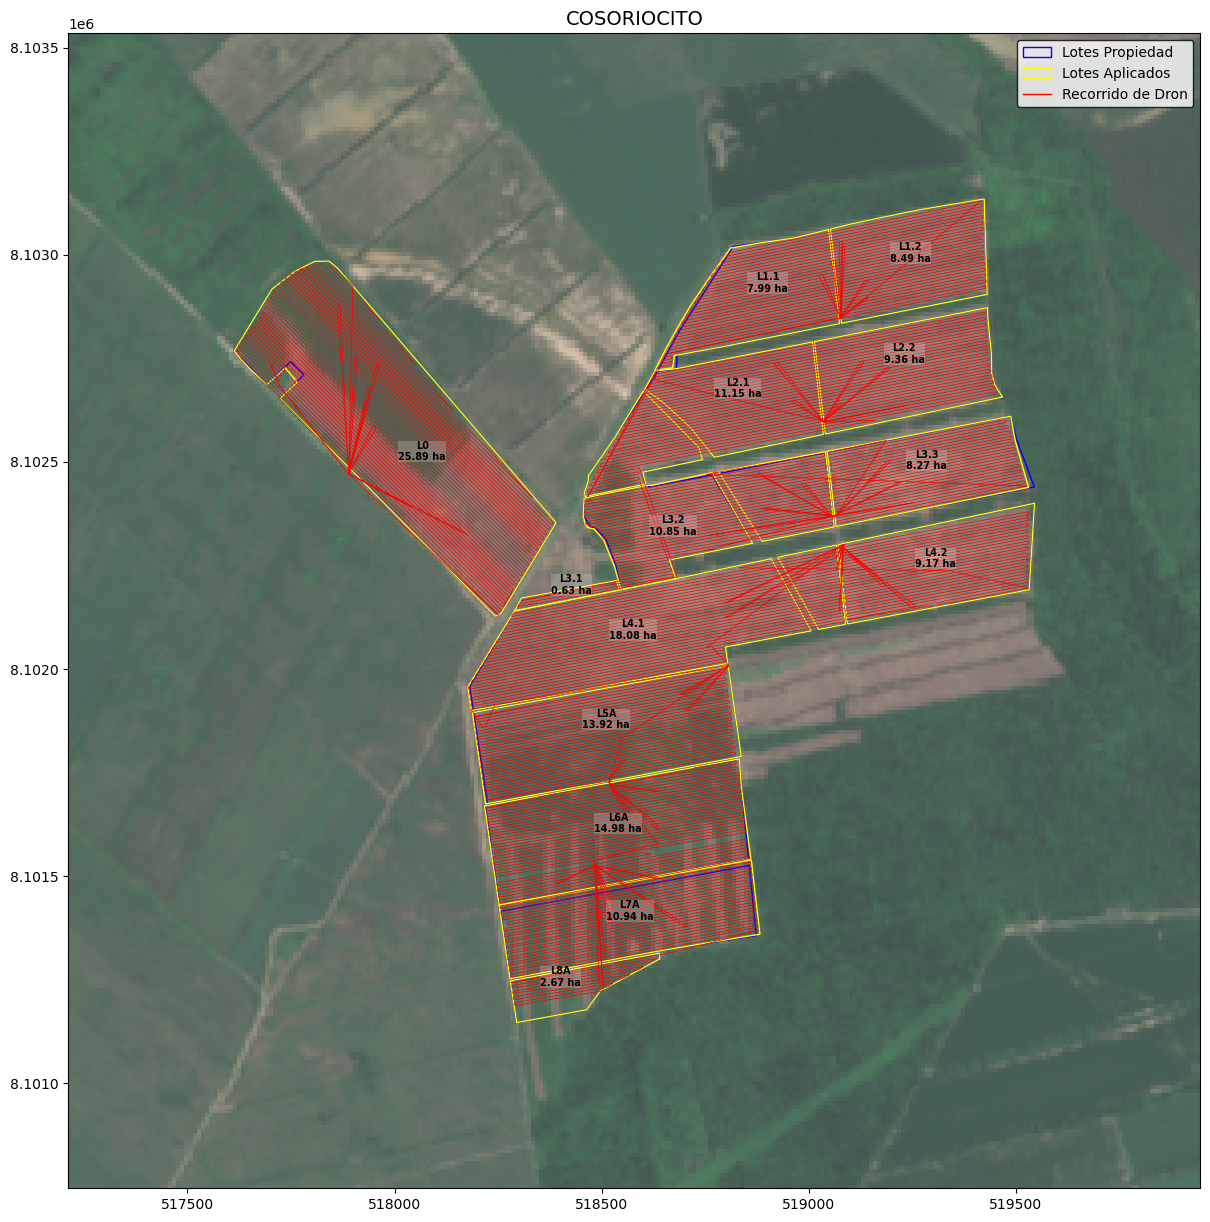

In [25]:
parte = obtener_propiedad_por_idd(idd)
shp_recorrido = gdf_recorridos[gdf_recorridos['idd']==idd]
prop = gdf_cat[gdf_cat['unidad_01'] == cod_prop]
path_plano = RUTA_UNIDAD_ONE_DRIVE + r"\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\plano_aux_pulverizacion.jpg"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"
#path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2024-01-30_UTM.tif"
generar_plano_pulv(prop, parte, shp_recorrido, path_tif, path_plano)

In [26]:
fecha = parte['fecha'].iloc[0]
df_cod_labor = obtener_cod_labor_actual()
cod_labor = df_cod_labor.iloc[0]['max']
new_cod_labor = F'PA-2025-{cod_labor + 1}'
new_cod_labor

'PA-2025-60'

In [27]:
data = {
    'n_labor': new_cod_labor, 
    'fecha' : parte['fecha'].iloc[0].strftime("%d-%m-%Y"),
    'nom_ca' : parte['unidad_04'].iloc[0],
    'cod_ca' : parte['unidad_03'].iloc[0],
    'nom_prop' : parte['unidad_02'].iloc[0],
    'cod_prop' : parte['unidad_01'].iloc[0],
    'inst' : int(parte['inst'].iloc[0]),
    'total_area_cat': round(parte['area'].sum(), 2),
    'total_pulv': round(parte['area_rocia'].sum(), 2),
    
    'temp' : parte['temp'].iloc[0],
    'viento' : parte['viento'].iloc[0],
    'humedad' : parte['humedad'].iloc[0],
    'temp_max' : parte['temp_max'].iloc[0],
    'temp_min' : parte['temp_min'].iloc[0],
    'tipo_cultivo' : parte['cultivo'].iloc[0],
    'tipo_desarrollo' : parte['desarrollo'].iloc[0],
    'num_vuelos' : parte['num_vuelos'].iloc[0],
    'horas_vuelo' : parte['horas_vuel'].iloc[0],
    'total_caudal' : parte['total_caud'].iloc[0],
}

In [28]:
data_c = collections.namedtuple("data", data.keys())(*data.values())
lotes = parte[['unidad_05', 'area', 'area_rocia']].copy()
lotes['porcen_rociado'] = lotes['area_rocia'] / lotes['area']
lotes['dif'] = lotes['area'] - lotes['area_rocia']
lotes.rename(columns={"unidad_05": "lote", "area": "area", "area_rocia": "area_r", "porcen_rociado": "porcen_r", "dif": "dif"}, inplace=True)
lotes = lotes.sort_values(by='lote')
lotes_c = []
for i, row in lotes.iterrows():
    l = collections.namedtuple("lote", dict(row).keys())(*dict(row).values())
    lotes_c.append(l)
totales_lotes = lotes.sum(numeric_only=True)
totales_lotes = dict(totales_lotes)
totales_lotes = collections.namedtuple("totales_lotes", totales_lotes.keys())(*totales_lotes.values())

In [29]:
texto = '''
--UTEA--
--SERVICIO DE DRONES EN AGRICULTURA--

ID Servicio: {nro_reg}
Fecha: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Propiedad: {prop}'''\
.format(
    nro_reg=data_c.n_labor, 
    fecha=data_c.fecha, 
    canero=data_c.nom_ca,
    cod_ca=data_c.cod_ca,
    prop=data_c.nom_prop)
    # Generar el código QR
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,)
qr.add_data(texto)
qr.make(fit=True)
img = qr.make_image(fill_color="black", back_color="white")
filename_qr = 'qr_pulv'
ruta_qr = RUTA_COMPLETA + '/planos/' + filename_qr + '.png'
# Guardar el código QR en un archivo
img.save(ruta_qr)

In [30]:
filename = f'{data_c.cod_ca}_SADA_{data_c.fecha}_{data_c.nom_ca}_{data_c.n_labor}'
filename = filename.replace('"','')

doc = DocxTemplate(RUTA_COMPLETA + "/templates/tpl_informe_pulv.docx")
in_line_plano = docxtpl.InlineImage(doc, image_descriptor=path_plano, width=Mm(150))
in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
context = {'data':data_c, 'lotes':lotes_c, 'lotes_t':totales_lotes, 'plano':in_line_plano, 'qr':in_line_qr}
doc.render(context)

doc.save(RUTA_COMPLETA + '/informes/_' + filename + '.docx')
actualizar_cod_labor_por_idd(idd, new_cod_labor)

✔️ Cod_Lobor: PA-2025-60 actualziado correctamente en idd: 59


In [31]:
insertar_datos_resumen(data_c)

✅ Registro insertado o actualizado exitosamente en RESUMEN de pulverización.
